# Aprendizaje basado en Ensembles

<img src ="https://i.imgur.com/OxLKD6t.png" width="700">

El aprendizaje basado en [Ensembles](https://scikit-learn.org/stable/modules/ensemble.html) intenta buscar una sinergia entre distintos modelos de aprendizaje computacional. El término proviene del [ámbito musical](https://en.wikipedia.org/wiki/Musical_ensemble), en el cual varias bandas o solistas se agrupan con un nuevo nombre para tocar juntos.

La premisa es que un conjunto de expertos será capaz de ofrecer mejores predicciones que los expertos por separado. Esto se consigue complementando las carencias de un modelo con otros modelos.

Los métodos Ensemble se distribuyen en dos grandes familias:

- **Métodos de promediado** (*averaging methods*): cuyo funcionamiento consiste en entrenar de forma paralela y de manera independiente varios modelos de aprendizaje para obtener la predicción final mediante una combinación de la predicción de los modelos por separado. Los modelos que se entrenan en esta familia suelen ser modelos robustos y complejos, que obtienen buenos resultados por sí mismos.

- **Métodos Boosting** (*boosting methods*): los modelos del ensemble se construyen de manera iterativa, intentando reducir el sesgo de la combinación de todos. A diferencia de los métodos de promediado, los modelos que se construyen en esta familia suelen ser modelos muy simples. Técnicamente nos basta con que el modelo obtenga precisiones superiores al 0.5

## Configuración y librerías

In [0]:
# Librerías comunes
import numpy as np
import os
import pandas as pd

# Fijamos una semilla para el PRNG de Numpy
np.random.seed(1337)

# Parámetros de Matplotlib
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

## Clasificación por votación

La idea detrás de un **Clasificador por Votación** ([`VotingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html)) es combinar clasificadores conceptualmente diferentes y utilizar un voto mayoritario (*hard*) o las probabilidades promedio pronosticadas (*soft-voting*) para predecir las etiquetas. 

Este clasificador puede ser útil para un conjunto de modelos con un rendimiento igualmente bueno, a fin de equilibrar sus debilidades individuales.

Vamos a generar un _dataset_ sintético con la función `make_moons` de sklearn que sirve para generar nubes de puntos con forma de lunas entrelazadas:

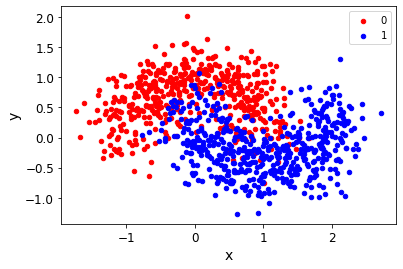

In [53]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=1000, noise=0.30, random_state=1337)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1337)

df = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
colors = {0:'red', 1:'blue'}
fig, ax = plt.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
plt.show()

Ahora, calcularemos la predicción uniendo los clasificadores *Logistic Regression*, *Naïve Bayes* y *SVC*:

In [0]:
from sklearn.ensemble import VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(random_state=42, solver='lbfgs')
nb_clf = GaussianNB()
svm_clf = SVC(random_state=42, gamma='auto')

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('nb', nb_clf), ('svc', svm_clf)],
    voting='hard')

In [55]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=42,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('nb',
                              GaussianNB(priors=None, var_smoothing=1e-09)),
                             ('svc',
                              SVC(C=1.0, break_ties=False, cache_size=200,
                                  class_weight=None, coef0=0.0,
   

In [56]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, nb_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.816
GaussianNB 0.816
SVC 0.864
VotingClassifier 0.816


En el caso anterior hemos configurado el `VotingClassifier` especificando el parámetro `voting='hard'` por lo que la salida del clasificador será la opinión mayoritaria del resto de clasificadores.

Y ahora probamos con una configuración `voting='soft'`, que trabaja con las probabilidades de que la muestra pertenezca a una clase en lugar de con la clase directamente. Además, es posible modificar el peso de la probabilidad de cada clasificador mediante el parámetro `weights`.

In [57]:
log_clf = LogisticRegression(random_state=42, solver='lbfgs')
nb_clf = GaussianNB()
svm_clf = SVC(random_state=42, gamma='auto', probability=True)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('nb', nb_clf), ('svc', svm_clf)],
    voting='soft',
    weights=[0.25, 0.25, 0.50])
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=42,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('nb',
                              GaussianNB(priors=None, var_smoothing=1e-09)),
                             ('svc',
                              SVC(C=1.0, break_ties=False, cache_size=200,
                                  class_weight=None, coef0=0.0,
   

In [58]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, nb_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.816
GaussianNB 0.816
SVC 0.864
VotingClassifier 0.844


# Bagging ensembles

El funcionamiento de estos métodos consiste en entrenar varias instancias de un mismo modelo de aprendizaje computacional, pero usando un subconjunto distinto de muestras seleccionadas aleatoriamente para cada entrenamiento.

En `sklearn` tenemos el meta-clasificador [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html#sklearn.ensemble.BaggingClassifier). Destacamos algunos de sus parámetros:

- `n_estimators`: permite definir el número de muestreos a ejecutar sobre el clasificador especificado.
- `max_samples`: porcentaje (o número) de muestras a utilizar en cada muestreo.
- `max_features`: porcentaje (o número`) de features a utilizar en cada muestreo.

In [0]:
from sklearn.ensemble import BaggingClassifier

bag_clf = BaggingClassifier(
    base_estimator=SVC(random_state=42, gamma='auto', probability=True), 
    n_estimators=20,
    max_samples=150, 
    max_features=2,
    n_jobs=-1, 
    random_state=42)

bag_clf.fit(X_train, y_train)

y_pred = bag_clf.predict(X_test)

In [60]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.844

La clase `BaggingClassifier` dispone de un atributo `oob_score_` (si se especifica el parámetro `oob_score=True`) que permite utilizar este meta-clasificador cuando se tiene un conjunto de datos pequeños y no queremos sacar una parte de él como conjunto de *test*. OOB son las siglas de *Out-of-bag* y representa una métrica que utiliza las muestras que no se han utilizado en el entrenamiento de cada uno de los árboles de decisión del ensemble como conjunto de test.

In [61]:
bag_clf = BaggingClassifier(
    SVC(random_state=42, gamma='auto', probability=True), 
    n_estimators=20,
    max_samples=150, 
    max_features=2,
    n_jobs=-1,
    oob_score=True, 
    random_state=42)

bag_clf.fit(X_train, y_train)

bag_clf.oob_score_

0.884

## AdaBoost

El principio básico de AdaBoost es ajustar una secuencia de aprendizajes débiles (es decir, modelos que sólo son ligeramente mejores que una clasificación aleatoria) usando versiones modificadas de los datos. Las predicciones de todos ellos se combinan finalmente mediante una votación por mayoría ponderada (o suma) para producir la predicción final. 

Las modificaciones de los datos en cada una de las iteraciones consisten en aplicar pesos $w_1, w_2, \dots, w_N$ a cada una de las $N$ muestras de entrenamiento. Inicialmente, estos pesos se fijan a $w_i=\frac{1}{N}$, de tal modo que en la primera iteración se produce un entrenamiento "débil" de los datos originales. En cada iteración sucesiva, los pesos de la muestra se modifican individualmente y el algoritmo de aprendizaje se vuelve a aplicar a los datos re-ponderados. En un paso determinado, los ejemplos de entrenamiento que fueron incorrectamente predichos por el modelod el paso anterior aumentan sus pesos, mientras que los pesos se reducen para los que fueron predichos correctamente. A medida que avanzan las iteraciones, los ejemplos difíciles de predecir reciben una influencia cada vez mayor, logrando, de este modo, que los clasificadores se concentren en las muestras que no han sido correctamente clasificadas.

`sklearn` nos proporciona la clase [AdaBoostClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html#sklearn.ensemble.AdaBoostClassifier).

In [62]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

ada_clf = AdaBoostClassifier(
    base_estimator=DecisionTreeClassifier(max_depth=1), 
    n_estimators=100, 
    random_state=42)

ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=1,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

In [0]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

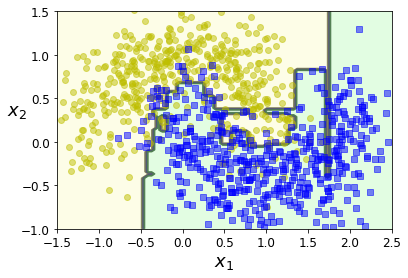

In [64]:
plot_decision_boundary(ada_clf, X, y)

## Stacked generalization

*Stacked generalization* es un método para combinar los estimadores para reducir sus sesgos. Concretamente, las predicciones de cada estimador individual se apilan y se usan como entrada a un estimador final para calcular la predicción. Este estimador final es entrenado a través de la validación cruzada.

El estimador final generalmente se alimenta únicamente de la salida de los clasificadores previos:

![Stacked generalization sin features](https://wolpert.readthedocs.io/en/latest/_images/stack_example_001.png)

No obstante, también es posible añadir a dicho estimador las muestras del conjunto de datos:

![Stacked generalization con features](https://wolpert.readthedocs.io/en/latest/_images/restack_graph.png)

En `sklearn` tenemos este clasificador implementado en la clase [`StackingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html#sklearn.ensemble.StackingClassifier). Los estimadores a combinar se deben definir en el parámetro `estimators` mientras que el estimador final se define en el parametro `final_estimator`. El parámetro `passthrough` permite definir si el estimador final se entrena sólo con la salida de los estimadores (`passthrough=False`, valor por defecto) o se usan también las muestras de entrada (`passthrough=True`).


In [65]:
from sklearn.ensemble import StackingClassifier

log_clf = LogisticRegression(random_state=42, solver='lbfgs')
nb_clf = GaussianNB()
svm_clf = SVC(random_state=42, gamma='auto', probability=True)

stack_clf = StackingClassifier(
    estimators=[('lr', log_clf), ('nb', nb_clf), ('svc', svm_clf)],
    final_estimator=LogisticRegression(),
    passthrough=False)

stack_clf.fit(X_train, y_train)

y_pred = stack_clf.predict(X_test)

accuracy_score(y_test, y_pred)

0.864

In [66]:
log_clf = LogisticRegression(random_state=42, solver='lbfgs')
nb_clf = GaussianNB()
svm_clf = SVC(random_state=42, gamma='auto', probability=True)

stack_clf = StackingClassifier(
    estimators=[('lr', log_clf), ('nb', nb_clf), ('svc', svm_clf)],
    final_estimator=LogisticRegression(),
    passthrough=True)

stack_clf.fit(X_train, y_train)

y_pred = stack_clf.predict(X_test)

accuracy_score(y_test, y_pred)

0.86